# Evaluate model for Vietnamese Stock Env

In [ ]:
import os
from pathlib import Path
path = Path(os.getcwd())
os.chdir(path.parent.absolute())

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import pandas_ta as ta
from stable_baselines3 import PPO, SAC
import gym
import matplotlib.pyplot as plt
from stable_baselines3.common.evaluation import evaluate_policy
import mt4_hst
import stock_env
from stock_env.utils import *
from stock_env.envs import *
from stock_env.feature.feature_extractor import *
from stable_baselines3.common.env_checker import check_env
import vectorbt as vbt
%matplotlib inline

In [ ]:
env = 'MultiStockContinuousEnv'
algo = 'ppo'
path = "../stock_datasets/"
feature_extractor = TrendFeatures()
name = f"{algo}_{env}_{feature_extractor.__class__.__name__}"
# name = 'ppo_MultiStockContinuousEnv_TrendFeatures'

# Total Portfolio

In [ ]:
total_name = f'histories_{name}'
df = pd.read_csv(f'temp/history/{total_name}.csv')
df.sort_values(by='time', inplace=True)
df.index = pd.to_datetime(df['time'])
portfolio_value = df['total_portfolio_value']
create_performance(portfolio_value.pct_change())

# Ticker history

In [ ]:
# ticker = 'SSI'
# ticker_name = f'ticker_history_{ticker}_{name}'

# for signal stock
# env = 'VietnamStockContinuousEnv'
# algo = 'ppo'
# ticker = "SSI"
# path = "../stock_datasets/"
# feature_extractor = TrendFeatures()
# ticker_name = f"{algo}_{env}_{feature_extractor.__class__.__name__}_{ticker}"

# specify name
ticker_name = "PPO_BufferWrapper_TrendFeatures_finservice"

df = pd.read_csv(f'temp/history/{ticker_name}.csv')
df.sort_values(by='time', inplace=True)
df.index = pd.to_datetime(df['time'])
portfolio_value = df['portfolio_value']

In [ ]:
df['ticker'].unique()

In [ ]:
create_performance(portfolio_value.pct_change())

In [ ]:
plot_trade_log_v2(df)

# Evaluate Random Stock Env Agent

In [ ]:
tickers = ["BSI"]
path = "../stock_datasets/"
init_cash = 20e3
feature_extractor = TrendFeatures()

env = RandomStockEnv(
    tickers = tickers,
    data_folder_path = path,
    feature_extractor = feature_extractor,
    init_cash = init_cash
)
from stock_env.wrappers.stack_obs import BufferWrapper
env = BufferWrapper(env, 5)
# from stable_baselines3 import SAC
model = PPO.load("log/PPO_BufferWrapper_TrendFeatures_finservice.zip", env=env)

# run model to get detailed information in the enviroment
done = False
obs = env.reset(eval_mode=True)
while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, _, done, _ = env.step(action)

# get data
df = env.get_history()
df.sort_values(by='time', inplace=True)
df.index = pd.to_datetime(df['time'])


    Annual return     :  17.49%
    Cumulative return :  466.18%
    Sharpe ratio      :  0.68
    Maximum Drawdown  : -43.29%
    Annual Volatility :  30.63%
    Value-At-Risk     :  nan%
    


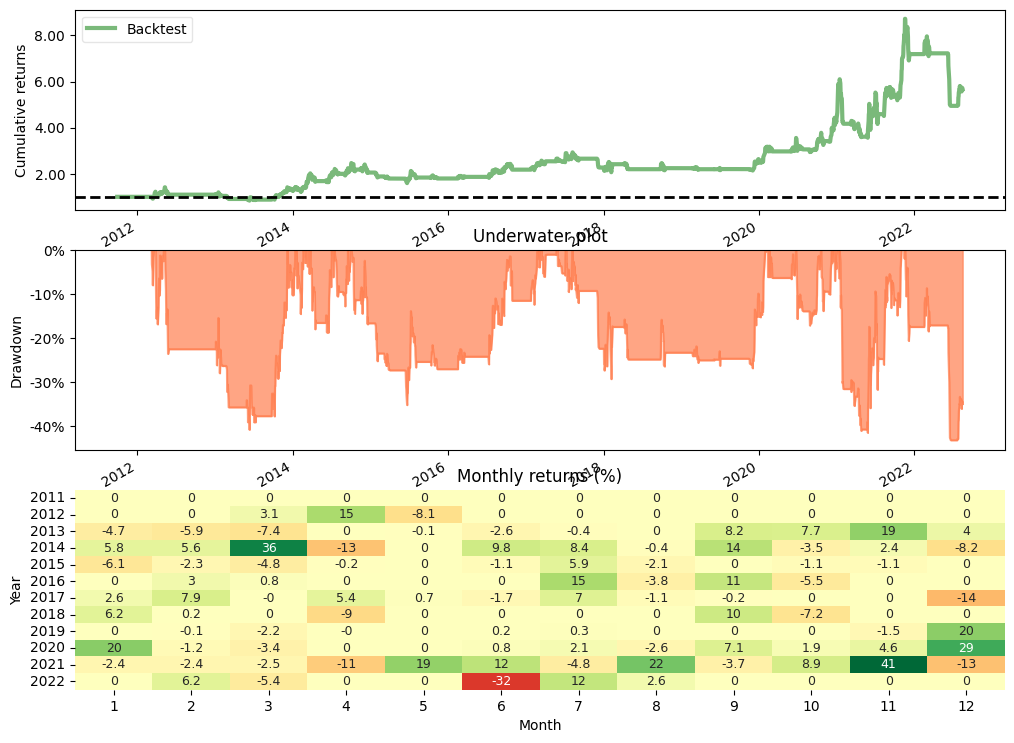

In [17]:
create_performance(df['portfolio_value'].pct_change())

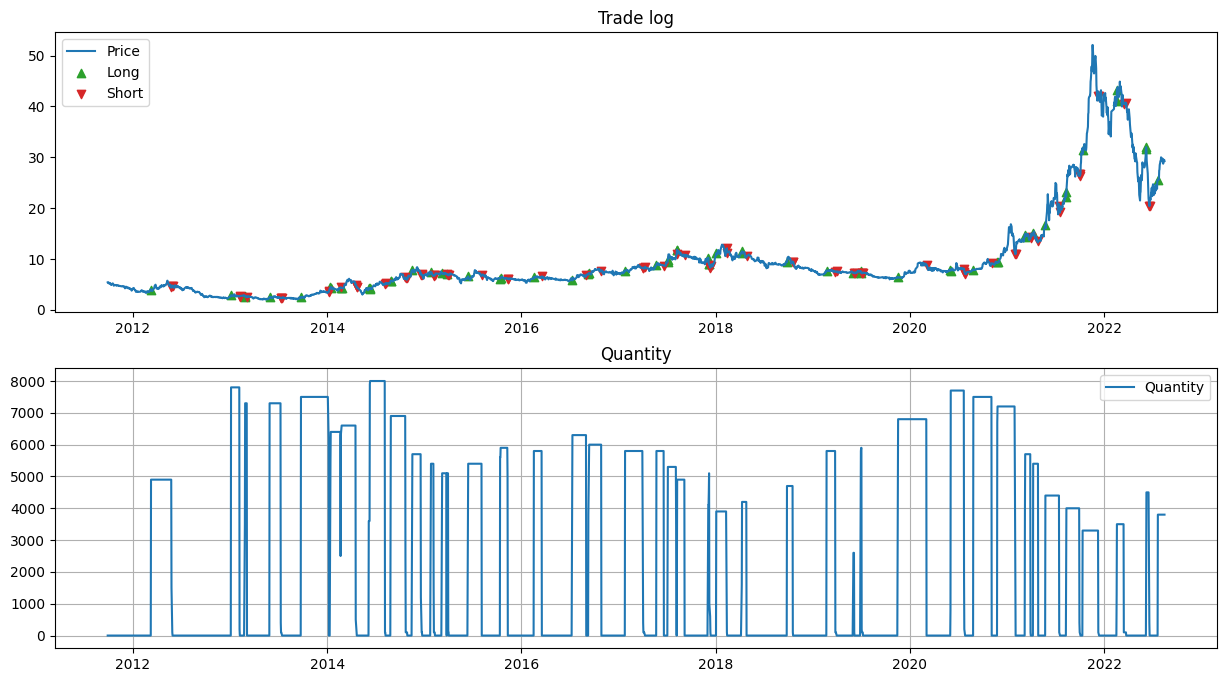

In [18]:
plot_trade_log_v2(df)

# Compare with from holdings

In [16]:
df.columns

Index(['time', 'open', 'high', 'low', 'close', 'volume', 'quantity', 'actions',
       'delta_shares', 'total_profit', 'portfolio_value', 'nav', 'cash',
       'step_reward', 'ticker', 'TS_Trends', 'ADX_20', 'AROOND_20',
       'AROONU_20', 'AROONOSC_20', 'STC_10_10_20_0.5', 'STCstoch_10_10_20_0.5',
       'NATR_20', 'RSI_20', 'CCI_20_0.015', 'EMA_ratio', 'DC_ratio',
       'above_MA', 'pv_from_holding', 'pv_from_strategy'],
      dtype='object')

In [ ]:
# portfolio value from hodling
df['pv_from_holding'] = vbt.Portfolio.from_holding(df.close, init_cash=20e3).value()

strategy_signals = df.ta.tsignals(df['TS_Trends'].fillna(0))
df['pv_from_strategy'] = vbt.Portfolio.from_signals(
    df.close, 
    entries=strategy_signals.TS_Entries, 
    exits=strategy_signals.TS_Exits,
    init_cash=20e3).value()

In [15]:
fig = df['portfolio_value'].vbt.plot_against(df['pv_from_holding'])
df['pv_from_strategy'].vbt.plot_against(df['pv_from_holding'], fig=fig)

FigureWidget({
    'data': [{'hoverinfo': 'skip',
              'line': {'color': 'rgba(0, 0, 0, 0)', 'width':…